In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
import time
from scipy.stats import shapiro, mannwhitneyu, norm
import numpy as np
from tqdm.auto import tqdm

## Задание 1: расчет RR

In [2]:
def retention (reg_data_link, auth_data_link, start_dt = '1970-01-01', end_dt = time.strftime("%Y-%m-%d"), period = 'without_restriction'):


#   Считываем данные
    reg_data  = pd.read_csv(reg_data_link,  sep=';')
    auth_data = pd.read_csv(auth_data_link, sep=';')
    
    
#   Преобразовываем даты и записываем в столбцы "cohort" и 'auth_dt'
    reg_data["cohort"]   = pd.to_datetime(reg_data['reg_ts'].swifter.apply(pd.to_datetime,   unit='s').dt.date)
    auth_data["auth_dt"] = pd.to_datetime(auth_data['auth_ts'].swifter.apply(pd.to_datetime, unit='s').dt.date)
    
#   Убираем лишние данные по датам до джойна для его облегчения
    reg_data  = reg_data.query('cohort >= @start_dt and cohort <= @end_dt')
    auth_data = auth_data.query('auth_dt >= @start_dt')
    
#   Джойним датафреймы
    df = reg_data.merge(auth_data, on='uid', how='left')

#   Группируем данные по принадлежности пользователя к когорте и дате захода в игру, агрегируя по кол-ву уникальных пользователей.
    df = df.groupby(['cohort', 'auth_dt'], as_index=False) \
                  .agg(user_count=('uid', 'nunique'))
    
#   Считаем номер периода захода пользователя в игру от даты его когорты
    df['period_number'] = (df.auth_dt - df.cohort).dt.days
    
#   Если задано ограничение по кол-ву периодов, фильтруем данные
    if period != 'without_restriction':
        df = df.query('period_number <= @period')
        
#   Переводим дату в строковый формат для корректного отображения в когоротной матрице
    df["cohort"] = df["cohort"].astype(str)
    
#   Создаем когортную таблицу с кол-вом активных пользователей
    cohort_pivot = df.pivot_table(index = 'cohort',
                                columns = 'period_number',
                                 values = 'user_count')
#   Создаем Retention-матрицу
    cohort_size      = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

#   Считаем максимальный Retention в матрице, для адаптирования шкалы раскраски
    max = retention_matrix.loc[:,1:].max().max()
    
#   Построили тепловую карту, отражаюущую когортный Retention по дням.
    sns.set(style='ticks')
    plt.figure(figsize=(15, 10))
    plt.title('Cohorts: User Retention')
    sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, fmt='.1%', vmax = max, cmap='coolwarm_r')

In [3]:
#   Задаем переменные для использования в функции

#   Указываем пути до файлов
reg_data_link  = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-sidorov-22/shared/problem1-reg_data.csv'
auth_data_link = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-sidorov-22/shared/problem1-auth_data.csv'

#   Указываем ограничение по датам когорт и кол-ву периодов, за которое хотим посмотреть RR. Это необзятальеные параметры, 
#   если их не указывать, то мат
start_dt = "2020-09-08"
end_dt   = "2020-09-22"
period   = 12

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


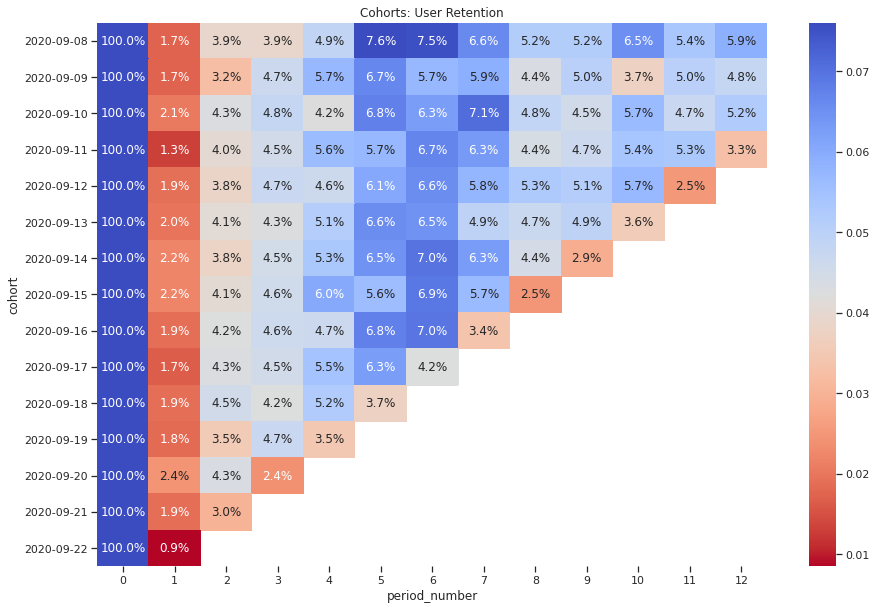

In [4]:
#   Применяем функцию
retention(reg_data_link, auth_data_link, start_dt, end_dt, period)

## Задание 2: А/Б тестирование

In [5]:
# Читаем данные
df_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-sidorov-22/project/Проект_1_Задание_2.csv', sep = ';')

Для начала познакомимся с данными, проведя короткий EDA (Exploratory data analysis)

In [6]:
# Посмотрим на DataFrame
df_2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [7]:
# Смотрим на размер датафрейма - в нем 404770 строк
df_2.shape

(404770, 3)

In [8]:
# Посчитаем кол-во уникальных user_id. Их в df столько же, сколько и строк - значит данные агрегированны по пользователям.
df_2.user_id.nunique()

404770

Посмотрим на описательную статистику выручки. Видим, что среднее значение выручки - 26, при этом у 75-й перцентиль равен 0, а максимальное значение - 37433.
Это означает две вещи:

a) Показатель явно не распределен нормально

б) Большинство пользователей не приносят денег

In [9]:
df_2.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

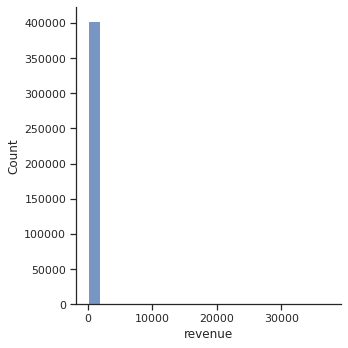

In [10]:
# Убедимся в этом на графике распределения пользователей по выручке
sns.displot(df_2.revenue)

Вторым этапом определим ключевые метрики, на основании которых будем принимать решение об эффективности акционных предложений.

Для правильного выбора метрик, конечно же, важно учитывать специфику и экономику бизнеса. Для этого у нас недостаточно вводных данных, однако если предположить, что в онлайн игре расходы составляют маленькую долю выручки и большая ее часть конвертируется в прибыль, то ARPU и ARPPU - хорошие метрики для принятия решения. При этом, скорее всего расходы компании равномерно делятся между всеми игроками и не зависят от участия игроков в аукционных предложениях, так что ARPU будет являться более основной метрикой, а ARPPU - второстепенной. Решение будем принимать, в первую очередь, исходя из изменений в ARPU, т.к. в результате изменения акционных предложений ARPPU может увеличиться, но пользователи могут начать меньше участвовать в акциях и средняя выручка и прибыль компании таким образом снизится.

Таким образом, гипотеза тестирования будет звучать следующим образом:
H0: Эффекта от изменения акционных предложений нет, то есть ARPU в тестовой и контрольной группах не имеют статзначимых различий
H1: Эффект от изменений есть, ARPU статзначимо различаются в тестовой и контрольной группах

Проверить данные гипотезы можно, например, с помощью t-test, в случае нормального распределения показателя.
Если показатель не распределен по нормальному закону распределения, то проверить гипотезы можно с помощью непараметричексого аналога t-теста — U-критерия Манна-Уитни, менее чувствительного к экстремальным отклонениям от нормальности и наличию выбросов, а также с помощью Бутстреп-анализа.

Проверять гипотезы будем на 0.05 уровне значимости

In [11]:
#   Разделяем данные на тестовую и контрольную группы
control = df_2.query('testgroup == "a"')
test    = df_2.query('testgroup == "b"')

#   Тестовая и контрольная группа платящих пользователей
control_p = control.query('revenue > 0')
test_p    =    test.query('revenue > 0')

In [12]:
#   Считаем изменение ARPU в группах. ARPU в тестовой группе увеличился на 5.3% 
ARPU_test    = test.revenue.sum()    / test.user_id.count()
ARPU_control = control.revenue.sum() / control.user_id.count()

round((ARPU_test - ARPU_control) / ARPU_control * 100, 1)

5.3

In [13]:
#   Считаем изменение ARPPU в группах. ARPPU в тестовой группе увеличился на 12.8% 
ARPU_test_p    = test_p.revenue.sum()    / test_p.user_id.count()
ARPU_control_p = control_p.revenue.sum() / control_p.user_id.count()

round((ARPU_test_p - ARPU_control_p) / ARPU_control_p * 100, 1)

12.7

In [14]:
#   Считаем конверсии в покупку. Конверсия в покупку в тестовой группе снизилась на 6.6%
CR_test    = test_p.user_id.count()    / test.user_id.count()
CR_control = control_p.user_id.count() / control.user_id.count()

round((CR_test - CR_control) / CR_control * 100, 1)

-6.6

Для того чтобы проанализировать статзначимость полученных различий необходимо определить распределена ли величина по 
нормальному закону, чтобы понять какой статистический критерий лучше использовать. Предварительно проанализируем
распределения с помощью визуализации.

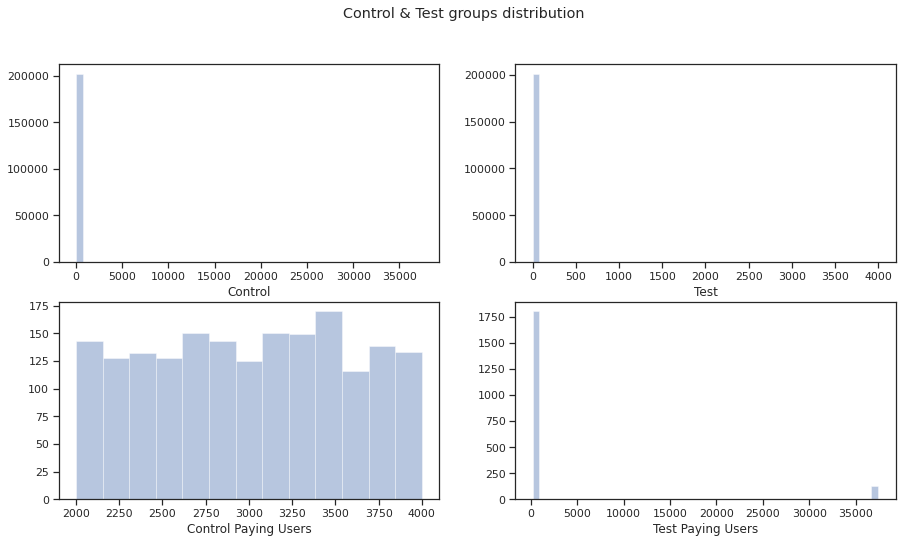

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle("Control & Test groups distribution")

sns.distplot(ax=axes[0, 0], x = control.revenue,   axlabel = 'Control',              kde = False)
sns.distplot(ax=axes[0, 1], x = test.revenue,      axlabel = 'Test',                 kde = False)
sns.distplot(ax=axes[1, 0], x = test_p.revenue,    axlabel = 'Control Paying Users', kde = False)
sns.distplot(ax=axes[1, 1], x = control_p.revenue, axlabel = 'Test Paying Users',    kde = False)

Кажется, что распределения отличаются от нормальных. Убедимся в этом с помощью критерия Шапиро-Уилка. 

Нулевая гипотеза теста Шапиро-Уилка Ho заключается в том, что случайная величина распределена по нормальному закону
Альтернативная же гипотеза H1 заключается в том, что закон распределения не является нормальным.

Критерий может неккоректно сработать на больших выборках, детектируя даже самые незначительные отклонения от нормальности.
Чтобы избежать этот недостаток будем использовать его на случайных 1000 значениях из выборок.

In [16]:
# Сделаем выборки в 1000 пользователей из каждой из групп
sample_control = control.sample(1000)
sample_test    = test.sample(1000)

#   Проводим тест Шапиро-Уилка на выборках
print('control:', shapiro(sample_control.revenue))
print('test:'   , shapiro(sample_test.revenue))

control: ShapiroResult(statistic=0.021987199783325195, pvalue=0.0)
test: ShapiroResult(statistic=0.06561797857284546, pvalue=0.0)


p-value в обоих группах равно нулю, следовательно H0 отклоняется даже при очень высоком уровне значимости, а это подтверждает тот факт, что показатель не имеет нормального распределения.

Т.к. показатель не распределен по нормальному закону, для проверки гипотез воспользуемся критерием Манна-Уитни.

In [17]:
#    Применяем критерий Манна-Уитни
mannwhitneyu(control.revenue, test.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

Т.к. p-value > α = 0.05, мы не отвергаем H0 в пользу H1. Однако p-значение все-таки достаточно маленькое, поэтому не помешает проверить выводы с помощью другого метода - Бутстреп-анализа, основанного на многократной генерации выборок на базе имеющейся выборки.

In [18]:
#   Прописываем функцию для проведения Bootstra-анализа
def get_bootstrap(
        data_column_1,
        data_column_2,
        boot_it = 1000,
        statistic = np.mean,
        bootstrap_conf_level = 0.95):
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('booted_data')
    plt.ylabel('frequency')
    plt.title("Histogram of booted_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants"   : quants, 
            "p_value"  : p_value}

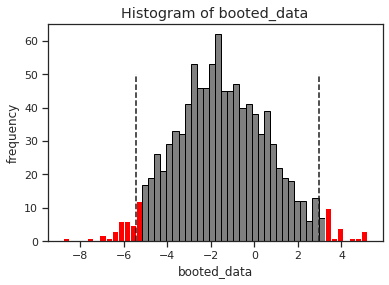

In [19]:
booted_data = get_bootstrap(control.revenue, test.revenue)

In [20]:
booted_data["p_value"]

0.49809556078333406

p-value больше порогового значения в 0.05, гипотеза о статзначимости различий отвергается.

In [21]:
booted_data["quants"]

,0
0.025,-5.439742
0.975,2.957505


Вывод:
Хоть ARPU и ARPPU в тестовой группе оказались выше, чем в контрольной, это не позволяет нам сделать вывод о том, что новые акционные предложения эффективны. Два статистических метода (Критерий Манна-Уитни и Бутстреп анализ) не показали статистически значимых изменений в основной и самой важной метрики для данной компаннии - ARPU, а значит различия показателя в тестовой и контрольной группах случайны.

В таком случае мы не можем сделать вывод о выигрыше тестового варианта акционных предложений и рекомендуем вернуться к контрольному варианту акционных предложений.

## Задание 3

Все метрики смотрим в динамике: до акции, во время и после, сопосвтавляя уровень интереса к игре до акции и после. Для оценки проведения тематического события я предлагаю проанализировать следующие метрики:

a) денежные: показывают динамику интереса и вовлеченность со стороны пользователей в деньгах
1) ARPU: средний чек среди всех пользвателей 
2) ARPPU: средний чек среди всех пользвателей среди активных/платящих пользователей 
3) Конверсия в покупку

b) неденежные: показывают динамику аудитории и ее вовлеченность
1) Renetion/Churn rate: резкий приток/отток пользователей сигнализирует о положительном/негативном пользовательском опыте и высоком/низком интересе к событию в целом. 
2) DAU: активное привлечение аудитории также является положительным индикатором, который может оказать влияние на денежные метрики 
3) ASL/Средняя длина сессии: характеризует вовлеченность пользователей 
4) Кол-во сессий: рост кол-ва открытия приложения может свидетельствовать о привыкании пользователя к приложению и нормализации уровня интереса, что благоприятно влияет на retention/churn rate 
5) Интервал между сессиями: чем меньше, тем лучше 
6) k factor: чем чаще пользователи приглашают других пользователей, тем выше виральность приложения, что благоприятно влияет на органический рост, компенсируя платные способы привлечения
Также необходимо анализировать конверсию в разрезе воронки уровней для управления оттока пользователей

Для оценки усложненной механики с потенциальным откатом уровней при неудачной попытке я бы предложил оценить следующие показатели

а) игровые
1) Среднее и медианное кол-во попыток у пользовтелей, прошедших все уровни 2) Среднее время прохождения всех уровней 3) Среднее кол-во откатов среди пользователей

b) бизнесовые
1) Кол-во крашей приложения 2) Кол-во продленных подписок 3) Среднее время первой покупки (сокращение метрики в сравнении со старой механикой помогут сделать выводы о том насколько новый формат стимулирует пользователя приобретать доп услуги) 4) отзывы/рейтинги (прямое влияние игрового опыта)

Аналогично замечанию выше необходимо скорректировать воронку под новый механизм и анализировать конверсию по уровням